--- Fitting Prophet Model ---


23:19:30 - cmdstanpy - INFO - Chain [1] start processing
23:19:43 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



--- Starting Cross-Validation ---


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0


Cross-validation performance metrics (aggregated by Prophet):
          horizon           mse        rmse         mae      mape     mdape  \
0 0 days 03:00:00   8822.374726   93.927497   76.106679  0.007570  0.005461   
1 0 days 04:00:00   6119.493916   78.227194   65.792640  0.006693  0.005946   
2 0 days 05:00:00  14837.249303  121.808248   96.050683  0.009699  0.008312   
3 0 days 06:00:00  45458.430399  213.209827  169.198405  0.016530  0.013412   
4 0 days 07:00:00  46074.545791  214.649821  166.805663  0.015939  0.013209   

      smape  coverage  
0  0.007559  1.000000  
1  0.006669  1.000000  
2  0.009662  0.961538  
3  0.016515  0.807692  
4  0.015957  0.793706  

--- Performance Metrics for Specific Horizons ---

Horizon: 1 hours
  MAE: 91.5062
  MSE: 12684.2843
  RMSE: 112.6245
  R2 Score: 0.9911
  MAPE: 0.8561%

Horizon: 6 hours
  MAE: 235.5114
  MSE: 77605.6645
  RMSE: 278.5779
  R2 Score: 0.8357
  MAPE: 2.2544%

Horizon: 12 hours
  MAE: 196.8646
  MSE: 45301.8665
  RMSE:

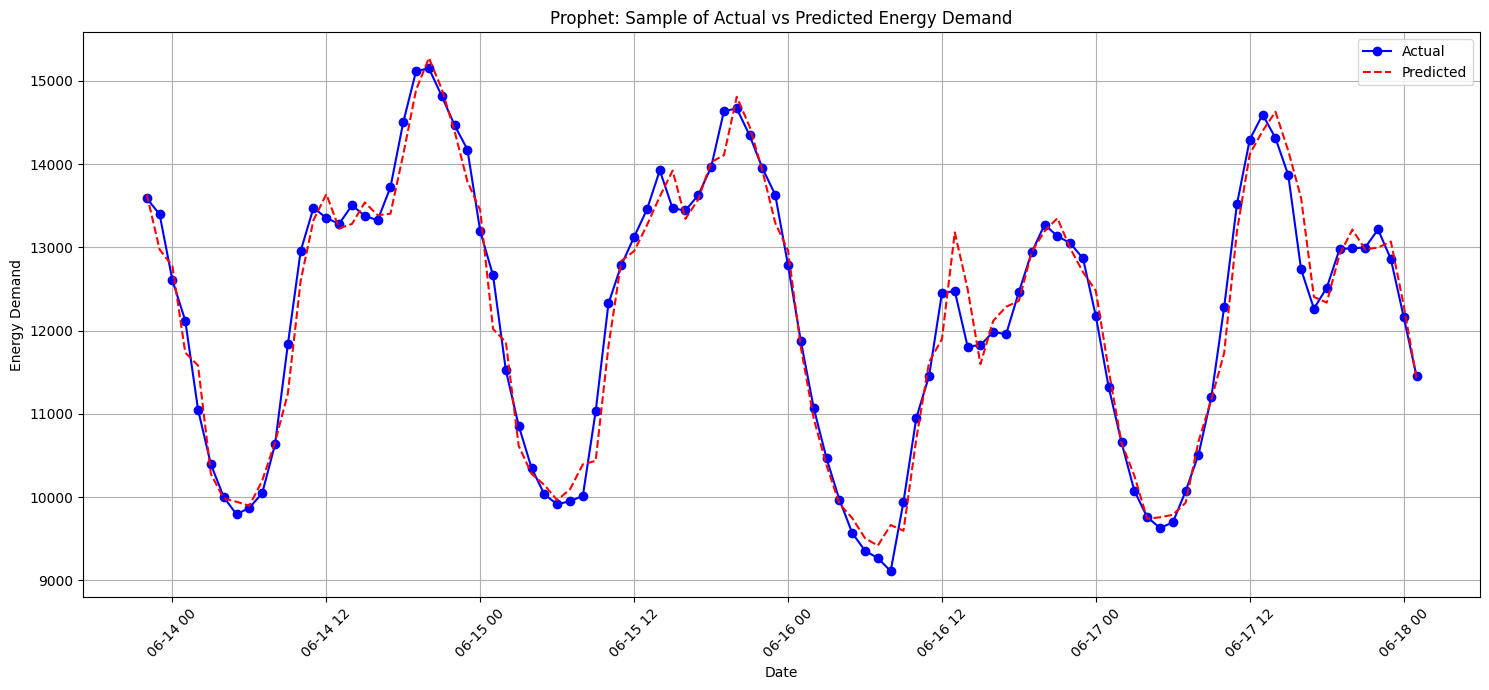


--- Plotting Prophet Components ---


KeyError: 'ds'

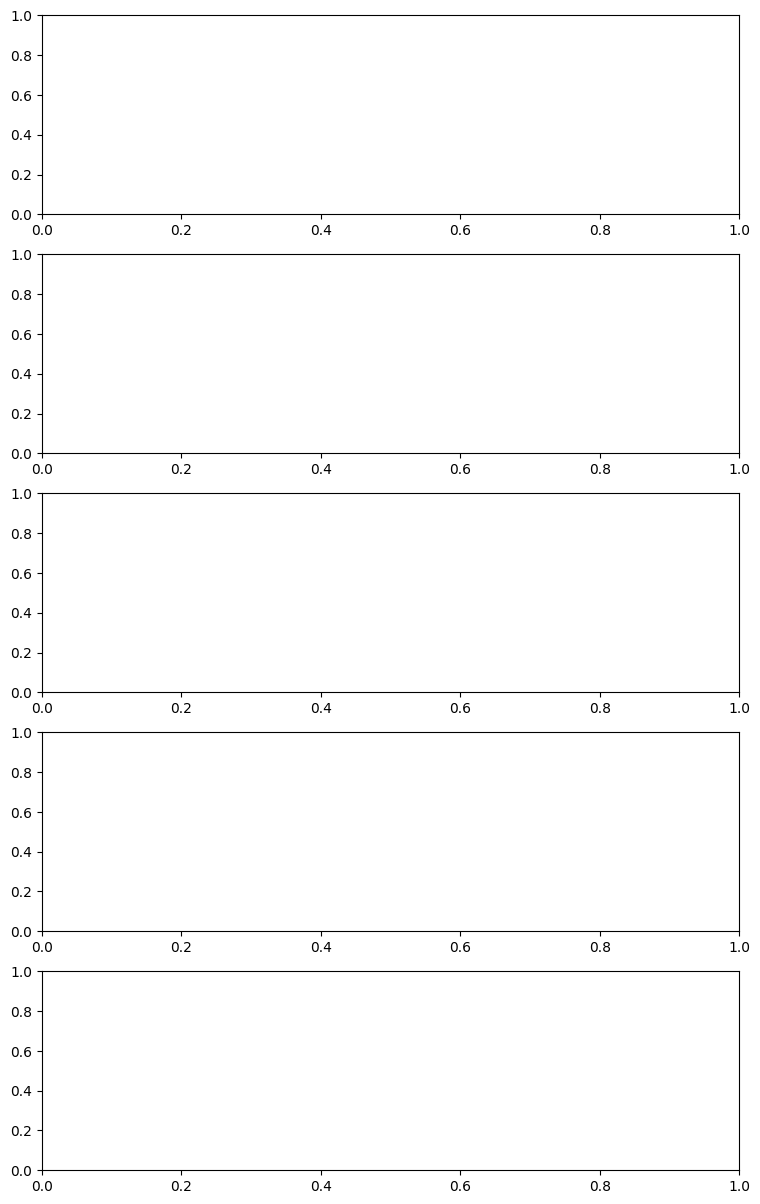

In [25]:
# Los Angeles Energy Demand Forecasting with Prophet (Updated & Corrected)
#
# This script uses Facebook's Prophet library for energy demand forecasting in Los Angeles.
#
# Updates:
# - Corrected a KeyError by manually calculating the 'horizon' column for metric evaluation.
# - Multi-Horizon Forecasting: Cross-validation is performed with a 24-hour horizon,
#   and performance metrics are calculated for 1, 6, 12, and 24-hour ahead forecasts.
# - Additional Metrics: Evaluation now includes MAE, MSE, RMSE, R², and a robust MAPE
#   for each specific forecast horizon.

#REMOVED TEMP

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# --- 1. Data Loading and Feature Engineering ---
# Load the dataset
# Make sure to replace 'Los Angeles.xlsx' with the correct path if the file is not in the same directory.
try:
    data = pd.read_excel('/Users/rushilkukreja/Downloads/mahabir/Los Angeles.xlsx')
except FileNotFoundError:
    print("Error: 'Los Angeles.xlsx' not found. Please ensure the dataset is in the correct directory.")
    exit()

data.dropna(inplace=True)
data['Time'] = pd.to_datetime(data['Time'])
df = data.rename(columns={'Time': 'ds', 'EnergyDemand': 'y'})

# Create time-based features
df['Hour'] = df['ds'].dt.hour
df['DayOfWeek'] = df['ds'].dt.dayofweek
df['Month'] = df['ds'].dt.month
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Create lag features
for lag in range(1, 25):
    df[f'Lag_{lag}'] = df['y'].shift(lag)

# Create interaction features
df['Temp_Humidity_Interaction'] = df['Temperature'] * df['RelativeHumidity']

df.dropna(inplace=True)

# --- 2. Prophet Model Training ---
model = Prophet()

# Add regressors
model.add_regressor('DewPoint')
model.add_regressor('WindSpeed')
model.add_regressor('Pressure')
model.add_regressor('RelativeHumidity')
model.add_regressor('Hour')
model.add_regressor('DayOfWeek')
model.add_regressor('Month')
model.add_regressor('IsWeekend')
model.add_regressor('Temp_Humidity_Interaction')

for lag in range(1, 25):
    model.add_regressor(f'Lag_{lag}')

print("--- Fitting Prophet Model ---")
model.fit(df)

# --- 3. Cross-Validation and Evaluation ---
print("\n--- Starting Cross-Validation ---")
# Perform cross-validation with a horizon that covers all our time steps
df_cv = cross_validation(model, initial='365 days', period='180 days', horizon='24 hours', parallel="processes")

# Display aggregated performance metrics from Prophet
df_p = performance_metrics(df_cv)
print("\nCross-validation performance metrics (aggregated by Prophet):")
print(df_p.head())

# Define a robust MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    if np.sum(non_zero_indices) == 0:
        return 0
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

# Calculate and display metrics for our specific horizons
print("\n--- Performance Metrics for Specific Horizons ---")
# FIX: Calculate the 'horizon' column manually from 'ds' and 'cutoff'
df_cv['horizon'] = df_cv['ds'] - df_cv['cutoff']
df_cv['horizon_hours'] = df_cv['horizon'].dt.total_seconds() / 3600
horizons = [1, 6, 12, 24]

for h in horizons:
    df_h = df_cv[df_cv['horizon_hours'] == h]
    if not df_h.empty:
        mae = mean_absolute_error(df_h['y'], df_h['yhat'])
        mse = mean_squared_error(df_h['y'], df_h['yhat'])
        rmse = np.sqrt(mse)
        r2 = r2_score(df_h['y'], df_h['yhat'])
        mape = mean_absolute_percentage_error(df_h['y'], df_h['yhat'])

        print(f'\nHorizon: {h} hours')
        print(f'  MAE: {mae:.4f}')
        print(f'  MSE: {mse:.4f}')
        print(f'  RMSE: {rmse:.4f}')
        print(f'  R2 Score: {r2:.4f}')
        print(f'  MAPE: {mape:.4f}%')
    else:
        print(f'\nNo data for horizon: {h} hours')


# --- 4. Final Forecast and Plotting ---
print("\n--- Generating Final Forecast and Plots ---")
future = df.drop(columns=['y'])
forecast = model.predict(future)

# Join forecast with actuals for plotting
df.set_index('ds', inplace=True)
forecast.set_index('ds', inplace=True)
aligned_df = df.join(forecast[['yhat']], how='inner')

# Plot a sample of the results
sample_period = 100
plt.figure(figsize=(15, 7))
plt.plot(aligned_df.index[-sample_period:], aligned_df['y'].iloc[-sample_period:], label='Actual', color='b', marker='o')
plt.plot(aligned_df.index[-sample_period:], aligned_df['yhat'].iloc[-sample_period:], label='Predicted', color='r', linestyle='--')
plt.title('Prophet: Sample of Actual vs Predicted Energy Demand')
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Prophet components
print("\n--- Plotting Prophet Components ---")
fig_components = model.plot_components(forecast)
plt.show()

